In [352]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd

In [353]:
#if i want to include SMA/stock data for same company, need to scrape function not just symbol
def TimeSeriesDaily_df(stock_name):
    """
    Read a CSV file from a URL and return a DataFrame with symbol as the last column.
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_name}&outputsize=full&apikey=98WO4EK4CGOBTPQR&datatype=csv'
    df = pd.read_csv(url)
    df['symbol'] = stock_name
    return df
    

In [354]:
def TimeSeriesIntraday_df(stock_name):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={stock_name}&interval=1min&outputsize=full&apikey=98WO4EK4CGOBTPQR&datatype=csv'
    df = pd.read_csv(url)
    df['symbol'] = stock_name
    return df
    

In [355]:
def QuoteEndpoint_df(stock_name):
    url = f'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={stock_name}&interval=1min&outputsize=full&apikey=98WO4EK4CGOBTPQR&datatype=csv'
    df = pd.read_csv(url)
    df['symbol'] = stock_name
    return df
    

In [6]:
daily_df = TimeSeriesDaily_df('TSLA')

In [9]:
intraday_df = TimeSeriesIntraday_df('TSLA')

In [10]:
intraday_df = intraday_df[::-1].reset_index(drop=True)
intraday_df['timestamp'] = pd.to_datetime(intraday_df['timestamp'])
mask = ((intraday_df['timestamp'].dt.time >= pd.Timestamp('9:30:00').time()) & (intraday_df['timestamp'].dt.time <= pd.Timestamp('16:00:00').time()))
intraday_open_df = intraday_df.loc[mask]
intraday_close_df = intraday_df.loc[~mask]
intraday_open_df

,timestamp,open,high,low,close,volume,symbol
330,2025-09-11 09:30:00,350.170,350.4500,348.5200,349.2700,732906,TSLA
331,2025-09-11 09:31:00,349.310,349.6300,348.7300,349.2083,289377,TSLA
332,2025-09-11 09:32:00,349.230,349.9300,348.3600,348.7338,355214,TSLA
333,2025-09-11 09:33:00,348.730,349.9200,348.2501,349.5816,343646,TSLA
334,2025-09-11 09:34:00,349.560,350.3300,349.4950,350.1726,314949,TSLA
...,...,...,...,...,...,...,...
20876,2025-10-10 15:56:00,413.870,414.0700,413.4800,413.5550,381745,TSLA
20877,2025-10-10 15:57:00,413.590,414.3000,413.3800,414.0300,439384,TSLA
20878,2025-10-10 15:58:00,414.075,414.1745,413.7000,413.8700,409379,TSLA
20879,2025-10-10 15:59:00,413.850,413.8600,413.1500,413.2700,983439,TSLA


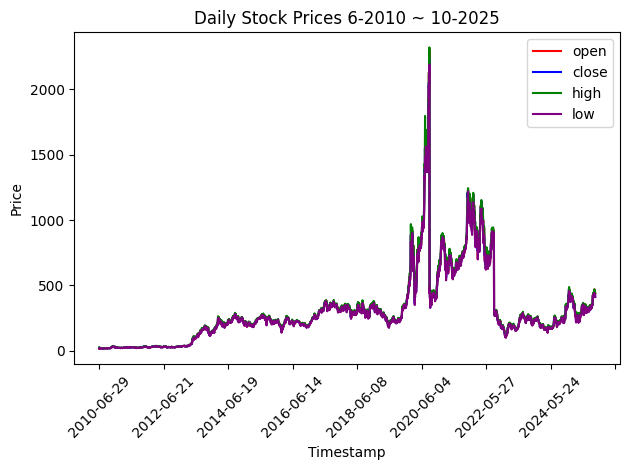

In [13]:
plt.plot(daily_df['timestamp'], daily_df['open'], color='red', label='open')
plt.plot(daily_df['timestamp'], daily_df['close'], color='blue', label='close')
plt.plot(daily_df['timestamp'], daily_df['high'], color='green', label='high')
plt.plot(daily_df['timestamp'], daily_df['low'], color='purple', label='low')
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Daily Stock Prices 6-2010 ~ 10-2025')
plt.legend()
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))  

plt.tight_layout()
plt.show()

In [704]:
def get_close_prices(portfolio):
    """
    Returns a DataFrame of close prices for the given portfolio.
    """
    data = {}
    for s in portfolio:
        df = TimeSeriesDaily_df(s)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.loc[df['timestamp'].dt.date > pd.Timestamp('2020, 10, 1').date()]
        prices = np.array(df['close'])[::-1]
        data[s] = prices
    df_combined = pd.DataFrame(data)
    df_combined['mean'] = df_combined.mean(axis=1)
    data_arr = df_combined.to_numpy()
    return data_arr.T

In [225]:
#home_construction_portfolio = ['DHI', 'LEN', 'PHM', 'TOL', 'NVR', 'HD', 'LOW', 'SHW', 'SPY']

In [361]:
portfolio = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NDAQ']

In [705]:
data_arr = get_close_prices(portfolio)
data_arr

array([[ 113.02   ,  116.5    ,  113.16   , ...,  254.04   ,  245.27   ,
         247.66   ],
       [ 206.19   ,  210.38   ,  205.91   , ...,  522.4    ,  510.96   ,
         514.05   ],
       [1455.6    , 1482.83   , 1451.02   , ...,  241.53   ,  236.57   ,
         244.15   ],
       ...,
       [ 415.09   ,  425.68   ,  413.98   , ...,  435.54   ,  413.49   ,
         435.9    ],
       [ 123.54   ,  124.87   ,  123.57   , ...,   91.4    ,   88.9    ,
          89.39   ],
       [ 777.60875,  796.22625,  776.965  , ...,  337.34125,  325.0025 ,
         331.905  ]], shape=(9, 1263))

In [365]:
def predict_price(M1, M2, l):
    ''' 
    Uses Koopman related DMD algorithm to predict future prices.
    l is the number of days in the future to predict
    ''' 
    U, s, Vt = np.linalg.svd(M1, full_matrices=False)
    Sigma_inv = np.diag(1.0/s)
    A_tilde = U.T @ M2 @ Vt.T @ Sigma_inv
    evals, evecs = np.linalg.eig(A_tilde)
    Phi = U @ evecs
    x0 = M1[:, 0].reshape((-1,1))
    b = np.linalg.pinv(Phi) @ x0

    n, r = Phi.shape
    preds = np.zeros((n, l))
    for t in range(1, l+1):
        D = np.diag(np.exp(np.log(evals) * t))
        x_t = Phi @ D @ b
        preds[:, t-1] = x_t.ravel().real
    
    return preds

In [366]:
def directional_accuracy(prediction, actual):
    '''
    Returns the accuracy of the predictions. The model is accurate if
    the predicted direction of the price change matches the actual direction.
    '''
    if prediction.shape != actual.shape:
        raise ValueError("Prediction and actual arrays must have the same shape.")

    diff_pred = prediction[:, 1:] - prediction[:, :-1]  
    diff_act = actual[:, 1:] - actual[:, :-1]     
    
    correct = np.sum((diff_pred * diff_act) > 0)
    return correct/diff_pred.size
    

In [367]:
def concat_data(accum, new_data):
    """
    Concatenate new_preds horizontally row by row to accum.
    Handles mixed dtypes by upcasting to object (or str if needed).
    """
    if accum is None:  
        return new_data.astype(object)

    accum = np.asarray(accum, dtype=object)
    new_data = np.asarray(new_data, dtype=object)

    return np.hstack((accum, new_data))

In [ ]:
def find_hotspot(data_arr, m_start, m_end, l_start, l_end):
    ''' 
    Finds potential hotspots based on the directional accuracy of price predictions. 
    Uses past 100 days of data to run through a range of parameters (m, l) to find
    combinations that yield an accuracy greater than 0.53.

    Returns a list of tuples (m, l, accuracy) for all combinations tested.
    '''
    accuracy_scores = []
    potential_hotspots = []
    preds_array = []
    actuals_array = []
    hotspots = []
    scores = []
    averages = []

    for m in range(m_start, m_end):
        scores_m_temp = []
        for l in range(l_start, l_end):
            scores_l_temp = []
            predictions = None
            actuals = None

            for t in range(m, data_arr.shape[1]-l, l): 
                M = data_arr[:, t-m:t]
                M1 = M[:, :-1]
                M2 = M[:, 1:]
                preds = predict_price(M1, M2, l) 
                actual = data_arr[:, t:t+l]
                scores_l_temp.append(directional_accuracy(preds, actual))
                predictions = concat_data(predictions, preds)
                actuals = concat_data(actuals, actual)
            preds_array.append(predictions)
            actuals_array.append(actuals)
            accuracy = np.sum(scores_l_temp) / len(scores_l_temp) #the mean of all accuracy scores for a given (m, l)
            accuracy_scores.append((m, l, accuracy))
            scores_m_temp.append(accuracy)
            if accuracy > 0.52: #arbitrary threshold
                potential_hotspots.append((m, l, accuracy))
        scores.append(scores_m_temp)
    
    for m1, l1, acc in potential_hotspots:
        if (m1 == m_start) or (m1 == m_end-1) or (l1 == l_start) or (l1 == l_end-1):
            continue
        idx_m = m1 - m_start
        idx_l = l1 - l_start
        assert(acc == scores[idx_m][idx_l]), 'Wrong indexing for potential hotspot'
        avg = (scores[idx_m-1][idx_l-1] + scores[idx_m-1][idx_l] + scores[idx_m-1][idx_l+1] +
               scores[idx_m][idx_l-1] + scores[idx_m][idx_l] + scores[idx_m][idx_l+1] +
               scores[idx_m+1][idx_l-1] + scores[idx_m+1][idx_l] + scores[idx_m+1][idx_l+1]) / 9
        averages.append(avg)
        if avg * 100 > 50.5:
            hotspots.append((m1, l1, acc, avg))
    
    sorted_hotspots = sorted(hotspots, key=lambda x: x[3], reverse=True) #x[2] to sort by individual acc score; x[3] to sort by average of neighbors acc scores

    return scores, potential_hotspots, sorted_hotspots, preds_array, actuals_array, accuracy_scores, averages

In [701]:
m_start, m_end = 5, 30
l_start, l_end = 2, 7
data_arr_samp = data_arr #[:, 1200:1450]  # Assuming 252 trading days per year

In [691]:
scores, potential_hotspots, hotspots, preds_array, actuals_array, accuracy_scores, averages = find_hotspot(data_arr_samp, m_start, m_end, l_start, l_end)

/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_55873/2942774990.py:17: RuntimeWarning: invalid value encountered in log
  D = np.diag(np.exp(np.log(evals) * t))


In [650]:
len(potential_hotspots)

4

In [652]:
sorted_potential_hotspots = sorted(potential_hotspots, key=lambda x: x[2], reverse=True)
print("Top 5 potential hotspots:")
sorted_potential_hotspots[:5]

Top 5 potential hotspots:


[(9, 2, np.float64(0.5315938942137025)),
 (9, 6, np.float64(0.5248931623931624)),
 (9, 3, np.float64(0.5247801758593126)),
 (9, 4, np.float64(0.5207667731629393))]

In [653]:
hotspots

[(9, 3, np.float64(0.5247801758593126), np.float64(0.5075880204842109)),
 (9, 4, np.float64(0.5207667731629393), np.float64(0.5061315442067604))]

In [548]:
def get_preds_and_actuals(m, l, m_start, l_start, l_end, preds, actuals, stock_num):
    ''' 
    Get my prediction values and the actual values, and plot them
    Args: 
        m: past days
        l: prediction horizon
        preds: preds_array from find_hospots
        actuals: actuals_array from find_hotspots
        stock_num (int): specific stock i want to see listed in portfolio
    '''
    diff = l_end - l_start
    idx = ((m - m_start) * diff) + (l - l_start)
    p, a = preds[idx][stock_num], actuals[idx][stock_num]

    plt.plot(p, color='blue', label='preds')
    plt.plot(a, color='red', label='actual')
    plt.title(f'Prediction vs. Actual Prices m={m}, l={l}, stock={portfolio[stock_num]}')
    plt.legend()
    plt.show()

    return preds[idx], actuals[idx]
    

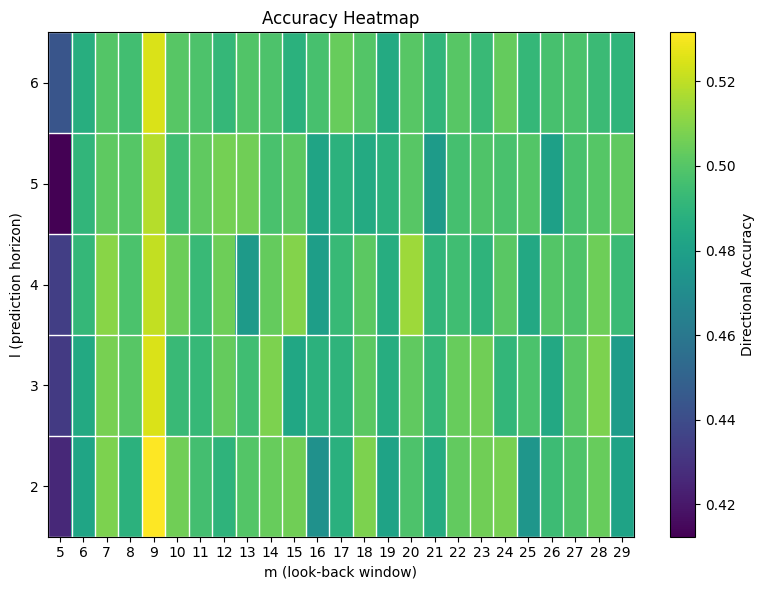

In [654]:
ms = sorted({m for m, l, score in accuracy_scores})
ls = sorted({l for m, l, score in accuracy_scores})

heatmap = np.zeros((len(ls), len(ms)))

for (m_val, l_val, score) in accuracy_scores:
    i = ls.index(l_val)   
    j = ms.index(m_val) 
    heatmap[i, j] = score

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(heatmap, origin='lower', aspect='auto')

ax.set_xticks(np.arange(len(ms)))
ax.set_xticklabels(ms)
ax.set_yticks(np.arange(len(ls)))
ax.set_yticklabels(ls)

ax.set_xticks(np.arange(len(ms) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(ls) + 1) - 0.5, minor=True)

ax.grid(which='minor', color='white', linestyle='-', linewidth=1)

ax.tick_params(which='minor', bottom=False, left=False)

ax.set_xlabel('m (look-back window)')
ax.set_ylabel('l (prediction horizon)')
ax.set_title('Accuracy Heatmap')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Directional Accuracy')

plt.tight_layout()
plt.show()

In [688]:
sorted_potential_hotspots = sorted(potential_hotspots, key=lambda x: x[2], reverse=True)
print("Top 5 potential hotspots:")
sorted_potential_hotspots[:5]

Top 5 potential hotspots:


[(9, 2, np.float64(0.5315938942137025)),
 (9, 6, np.float64(0.5248931623931624)),
 (9, 3, np.float64(0.5247801758593126)),
 (9, 4, np.float64(0.5207667731629393))]

In [656]:
hotspots

[(9, 3, np.float64(0.5247801758593126), np.float64(0.5075880204842109)),
 (9, 4, np.float64(0.5207667731629393), np.float64(0.5061315442067604))]

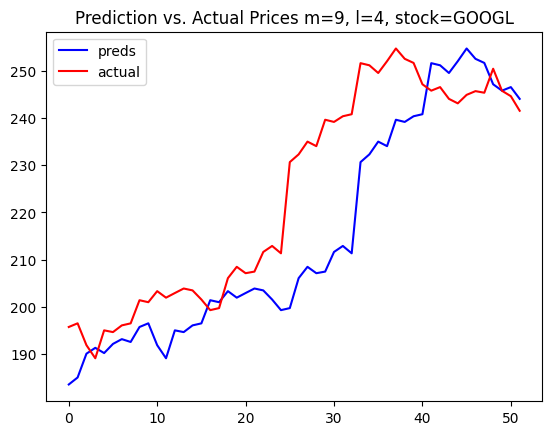

In [694]:
preds, actuals = get_preds_and_actuals(9, 4, m_start, l_start, l_end, preds_array, actuals_array, 2)

I want to compare 2 strategies based on their P&L. 

- Strategy 1: split up 10 years of data into 100 day increments. Then find a hotspot using the first 100 days, invest l future days; recalibrate the hotspot after l days, and repeat on 10 years of data.
- Strategy 2: Find a hotspot over 2 years of data, then use that hotspot for the next 6 months or something. Then recalibrate.
- Strategy 3: Find a hotspot over 10 years, and use the same hotspot for the next 200 days.

Further Exploration:
- Among identified hotspots, when is it better to use window that has the highest average of neighbors vs window that has highest individual accuracy score

Compare all these to the benchmark S&P 500.

In [660]:
def simulate_dynamic_strategy(bankroll, data_arr, hotspots, preds_array, actuals_array, total_days):
    """
    Simulate trades based on the best hotspot and calculate total PnL.
    
    Arguments:
        bankroll (int): Total money to invest.
        data_arr (np.ndarray): Stock price data, shape [n_stocks+1, n_days]
        hotspots (list): List of (m, l, acc, avg) hotspots.
        preds_array (list): List of prediction matrices from find_hotspot().
        actuals_array (list): List of actual matrices from find_hotspot().
        total_days (int): Total number of trading days to simulate.

    Returns:
        total_pnl (float): Total profit or loss over the period.
        trade_log (list): Detailed logs of each trade made.
    """

    n_stocks = data_arr.shape[0] - 1  # exclude the mean row
    total_pnl = 0.0
    trade_log = []
    day = 0

    while day + 1 < total_days:
        best_entry = None

        for i, (m, l, acc, avg) in enumerate(hotspots):
            m = int(m)
            l = int(l)

            # Ensure there is enough data before and after this day
            if day < m + 1 or day + l >= data_arr.shape[1]:
                continue

            # Extract predictions and actuals as floats
            pred_start = day - m
            pred = np.array(preds_array[i][:n_stocks, pred_start:pred_start + l], dtype=float)
            actual = np.array(actuals_array[i][:n_stocks, day:day + l], dtype=float)

            if pred.shape != actual.shape or pred.shape[1] < 2:
                continue

            # Identify tradable stocks (no NaN at entry/exit)
            valid_idx = ~np.isnan(pred[:, -1]) & ~np.isnan(pred[:, 0])
            if not np.any(valid_idx):
                continue  # no valid stocks for this hotspot

            delta = pred[valid_idx, -1] - pred[valid_idx, 0]
            if np.all(delta == 0):
                continue  # flat predictions, skip

            direction = np.sign(delta)

            best_entry = {
                "m": m,
                "l": l,
                "pred": pred,
                "actual": actual,
                "direction": direction,
                "valid_idx": valid_idx,
                "hotspot_index": i,
                "day": day,
            }
            break  # use first (best) valid hotspot

        if not best_entry:
            day += 1  # No trade today
            continue

        # Execute trade
        pnl = 0.0
        valid_idx = best_entry["valid_idx"]

        entry_prices = best_entry["actual"][:, 0][valid_idx]
        exit_prices  = best_entry["actual"][:, -1][valid_idx]
        direction    = best_entry["direction"]

        # Redistribute bankroll only among tradable stocks
        per_stock_investment = bankroll / len(entry_prices)

        for j in range(len(entry_prices)):
            entry = entry_prices[j]
            exit  = exit_prices[j]
            pos_dir = direction[j]
            if pos_dir == 0:
                continue
            stock_return = (exit - entry) if pos_dir > 0 else (entry - exit)
            pnl += stock_return / entry * per_stock_investment

        total_pnl += pnl
        trade_log.append({
            "entry_day": day,
            "exit_day": day + best_entry["l"] - 1,
            "m": best_entry["m"],
            "l": best_entry["l"],
            "hotspot_index": best_entry["hotspot_index"],
            "pnl": pnl,
        })

        day += best_entry["l"]  # move to next eligible day

    return total_pnl, trade_log


In [661]:
dynamic_pnl, dynamic_trades = simulate_dynamic_strategy(
    bankroll=1000,
    data_arr=data_arr_samp,
    hotspots=hotspots,
    preds_array=preds_array,
    actuals_array=actuals_array,
    total_days=data_arr_samp.shape[1]
)


In [662]:
dynamic_pnl

np.float64(-58.80538269715376)

In [664]:
def plot_pnl(trade_log):
    """
    Plots cumulative PnL over time based on the trade log.
    
    Arguments:
        trade_log (list of dict): Output from simulate_pnl(), each dict contains 'entry_day' and 'pnl'
    """
    if not trade_log:
        print("No trades to plot.")
        return

    days = []
    pnl_cumsum = []
    running_total = 0.0

    for trade in trade_log:
        days.append(trade["exit_day"])
        running_total += trade["pnl"]
        pnl_cumsum.append(running_total)

    plt.figure(figsize=(12, 6))
    plt.plot(days, pnl_cumsum, marker='o', linestyle='-')
    plt.xlabel("Trading Day")
    plt.ylabel("Cumulative PnL ($)")
    plt.title("Cumulative PnL Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

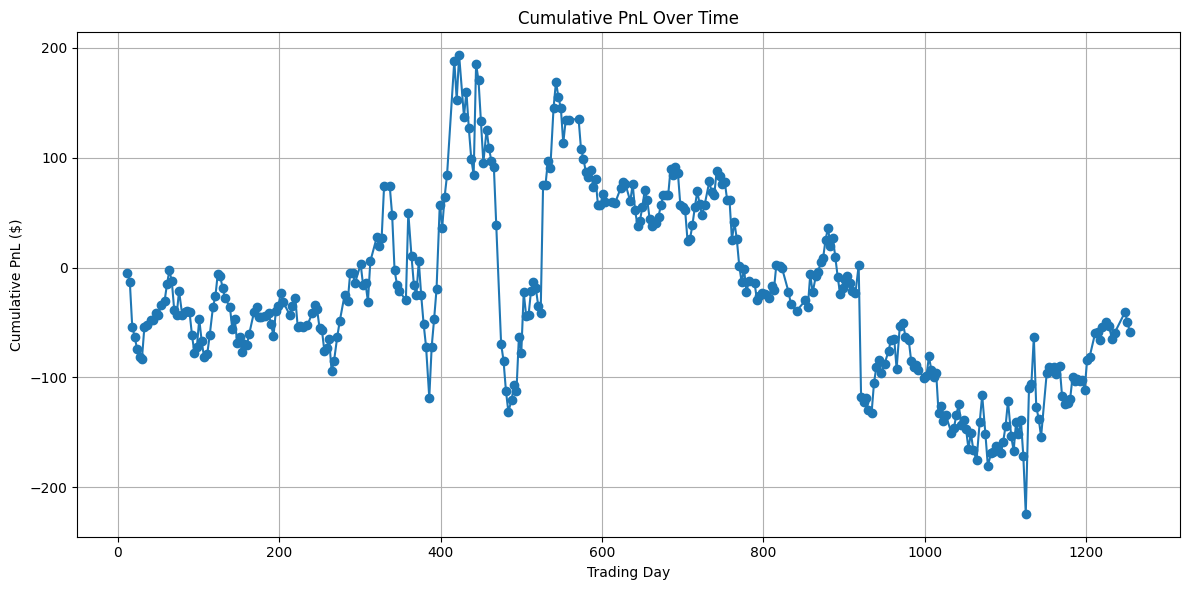

In [665]:
plot_pnl(dynamic_trades)

In [666]:
def simulate_static_strategy(bankroll, data_arr, window_len, step_n, m_start, m_end, l_start, l_end):
    """
    Runs a fixed-hotspot strategy where the best hotspot is re-selected every `step_n` days.

    Parameters:
        bankroll (int): Total capital to invest.
        data_arr (np.ndarray): Shape [n_stocks+1, n_days], includes mean row.
        window_len (int): Length of historical window to search for hotspots.
        step_n (int): Number of days to hold using the selected hotspot before re-selecting.
        m_start, m_end: Range for m values to search.
        l_start, l_end: Range for l values to search.

    Returns:
        total_pnl (float): Accumulated PnL.
        trade_log (list): Each trade window’s summary.
    """

    n_stocks = data_arr.shape[0] - 1
    total_days = data_arr.shape[1]
    day = window_len
    total_pnl = 0.0
    trade_log = []

    while day + step_n < total_days:
        # 1. Select best hotspot from historical window
        train_data = data_arr[:, day - window_len : day]
        scores, potential_hotspots, hotspots, preds_array, actuals_array, _, _ = find_hotspot(
            train_data, m_start, m_end, l_start, l_end
        )
        
        if not hotspots:
            day += step_n
            continue  # No hotspot found, skip this window

        # 2. Pick best hotspot by highest accuracy
        best = max(hotspots, key=lambda x: x[2])  # (m, l, acc, avg)
        m, l, acc, avg = best

        # 3. Start trading using (m, l) for next step_n days
        for t in range(day, day + step_n - l + 1, l):
            if t - m < 0 or t + l > total_days:
                continue

            M = data_arr[:n_stocks, t - m : t]
            M1 = M[:, :-1]
            M2 = M[:, 1:]
            pred = predict_price(M1, M2, l)
            actual = data_arr[:n_stocks, t : t + l]

            valid_idx = ~np.isnan(pred[:, -1]) & ~np.isnan(pred[:, 0]) & \
                        ~np.isnan(actual[:, 0]) & ~np.isnan(actual[:, -1])
            if not np.any(valid_idx):
                continue

            delta = pred[valid_idx, -1] - pred[valid_idx, 0]
            direction = np.sign(delta)
            if np.all(direction == 0):
                continue

            entry_prices = actual[:, 0][valid_idx]
            exit_prices  = actual[:, -1][valid_idx]

            per_stock_investment = bankroll / len(entry_prices)
            pnl = 0.0

            for j in range(len(entry_prices)):
                entry = entry_prices[j]
                exit  = exit_prices[j]
                dir_j = direction[j]
                if dir_j == 0:
                    continue
                stock_return = (exit - entry) if dir_j > 0 else (entry - exit)
                pnl += stock_return / entry * per_stock_investment

            total_pnl += pnl
            trade_log.append({
                "entry_day": t,
                "exit_day": t + l - 1,
                "m": m,
                "l": l,
                "accuracy": acc,
                "avg_neighbor_accuracy": avg,
                "pnl": pnl,
            })

        # 4. Advance by `step_n` days and repeat
        day += step_n

    return total_pnl, trade_log


/var/folders/h_/72q4z_1n5nn46z4ptpqc7y4h0000gn/T/ipykernel_55873/2942774990.py:17: RuntimeWarning: invalid value encountered in log
  D = np.diag(np.exp(np.log(evals) * t))


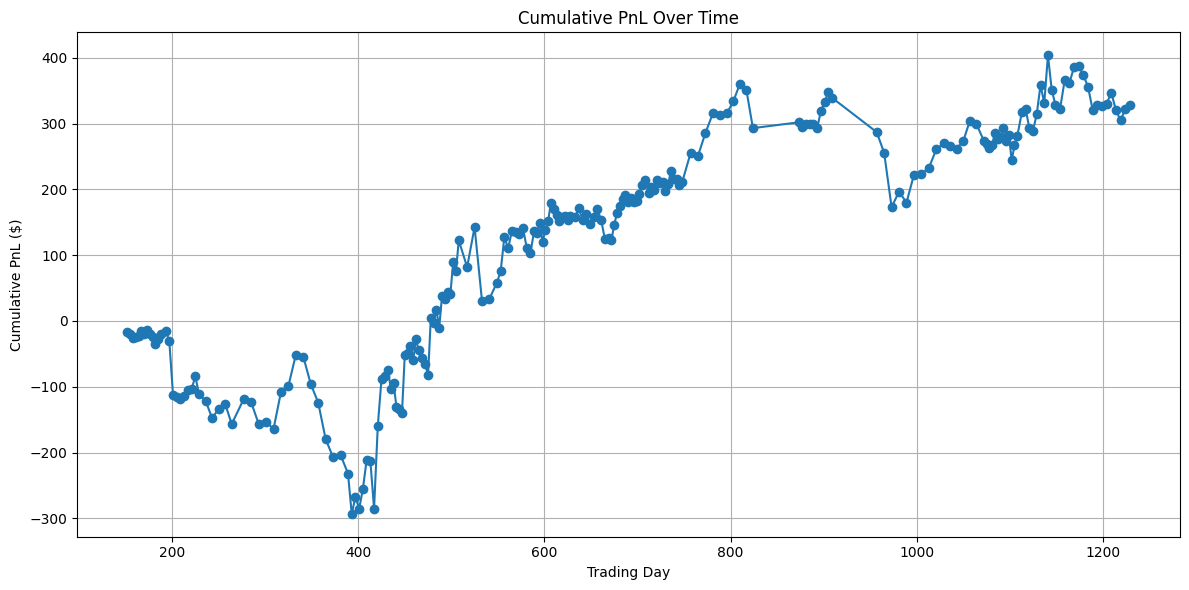

In [667]:
static_pnl, static_trades = simulate_static_strategy(
    bankroll=1000,
    data_arr=data_arr_samp,
    window_len=150,
    step_n=40,
    m_start=5,
    m_end=30,
    l_start=2,
    l_end=10
)

plot_pnl(static_trades)


In [668]:
static_pnl

np.float64(328.2662020856736)

In [698]:
def simulate_fixed_hotspot_full_run(bankroll, data_arr, m=9, l=4):
    """
    Run a naive DMD-based trading strategy without hotspot accuracy filtering.
    Every 4 days, uses the past 9 days to predict and trades based on that.
    
    Parameters:
        bankroll (int): Total bankroll to invest.
        data_arr (np.ndarray): [n_stocks+1, n_days] stock price matrix (including mean row).
        m (int): Number of past days to use for prediction (default=9).
        l (int): Holding period / prediction horizon (default=4).

    Returns:
        total_pnl (float): Total profit/loss from trading.
        trade_log (list): Each trade's details.
    """
    n_stocks = data_arr.shape[0] - 1
    total_days = data_arr.shape[1]
    total_pnl = 0.0
    trade_log = []
    
    day = m + 1  # first day with enough history

    while day + l <= total_days:
        M = data_arr[:n_stocks, day - m:day]
        M1 = M[:, :-1]
        M2 = M[:, 1:]

        # Predict using DMD
        pred = predict_price(M1, M2, l)
        actual = data_arr[:n_stocks, day:day + l]

        # Validate data (exclude NaNs)
        valid_idx = ~np.isnan(pred[:, -1]) & ~np.isnan(pred[:, 0]) & \
                    ~np.isnan(actual[:, 0]) & ~np.isnan(actual[:, -1])
        if not np.any(valid_idx):
            day += l
            continue

        delta = pred[valid_idx, -1] - pred[valid_idx, 0]
        direction = np.sign(delta)
        if np.all(direction == 0):
            day += l
            continue

        entry_prices = actual[:, 0][valid_idx]
        exit_prices  = actual[:, -1][valid_idx]
        per_stock_investment = bankroll / len(entry_prices)

        pnl = 0.0
        for j in range(len(entry_prices)):
            entry = entry_prices[j]
            exit  = exit_prices[j]
            dir_j = direction[j]
            if dir_j == 0:
                continue
            stock_return = (exit - entry) if dir_j > 0 else (entry - exit)
            pnl += stock_return / entry * per_stock_investment

        total_pnl += pnl
        trade_log.append({
            "entry_day": day,
            "exit_day": day + l - 1,
            "m": m,
            "l": l,
            "pnl": pnl
        })

        day += l  # advance to next trade window

    return total_pnl, trade_log


Total PnL using (m=9, l=4): $294.09


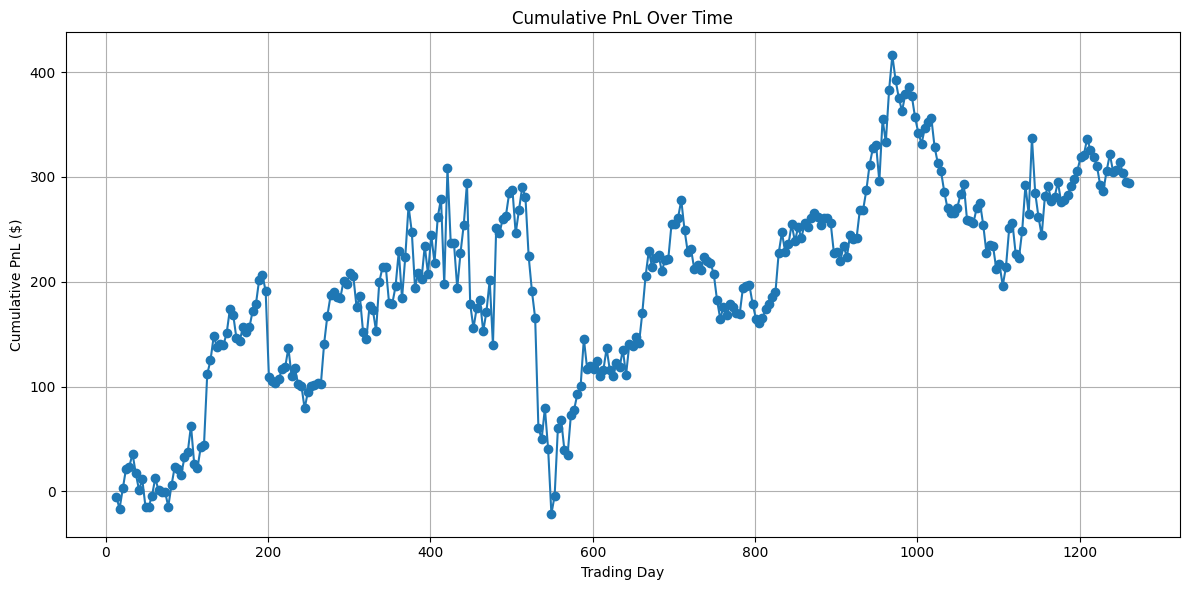

In [702]:
pnl, trade_log = simulate_fixed_hotspot_full_run(
    bankroll=1000,
    data_arr=data_arr_samp,
    m=9,
    l=4
)

print(f"Total PnL using (m=9, l=4): ${pnl:.2f}")
plot_pnl(trade_log)


In [97]:
def strategy_1(portfolio):
    '''
    Strategy 1: split up 10 years of data into 100 day increments.
    Then find a hotspot using the first 100 days, invest l future days; 
    recalibrate the hotspot after l days, and repeat on 10 years of data.
    '''
    hist_data_10_yrs = get_close_prices(portfolio)
    n = hist_data_10_yrs.shape[1]
    hist_data_10_yrs = hist_data_10_yrs[:, n//2:] # Use only the most recent 10 years of data

    delta = 0
    while delta < hist_data_10_yrs.shape[1]-100: #can adjust this 100 to change the number of days used to find hotspots
        data_arr = hist_data_10_yrs[:, delta:delta+100]
        accuracy_scores, potential_hotspots = find_hotspot(data_arr)
        if potential_hotspots:
            sorted_by_score = sorted(potential_hotspots, key=lambda tpl: tpl[2], reverse=True)
            #here we can build and call a function that checks if the average of its neighbors are also > 51% 
            #for now will just take the highest accuracy score and use the corresponding (m,l) as the hotspot
            m, l, accuracy = sorted_by_score[0]
            #build and call a function that invests and tracks P&L using (m,l) hotspot
            delta += l